In [1]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt

In [2]:
import DicomPipeLine 

In [3]:
main_data_source_path = r'/app/Data Pipeline/DataBase_1'
preprocessed_data_path = r'/app/Data Pipeline/TestDataBase_2'
sub_folders_to_scan_for = ['2','3','4','5']

In [4]:
main_data_source_path = r'F:\Final Year Project\Data Pipeline\DataBase_1'
preprocessed_data_path = r'F:\Final Year Project\Data Pipeline\TestDataBase_2'
sub_folders_to_scan_for = ['2','3','4','5']

In [5]:
path_obj = DicomPipeLine.Path_Settings(main_data_source_path, preprocessed_data_path, sub_folders_to_scan_for)

In [6]:
streamer = DicomPipeLine.Stream_Data(path_obj)

F:\Final Year Project\Data Pipeline\TestDataBase_2\1\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\TestDataBase_2\1\PET WB  (AC).pickle.gzip


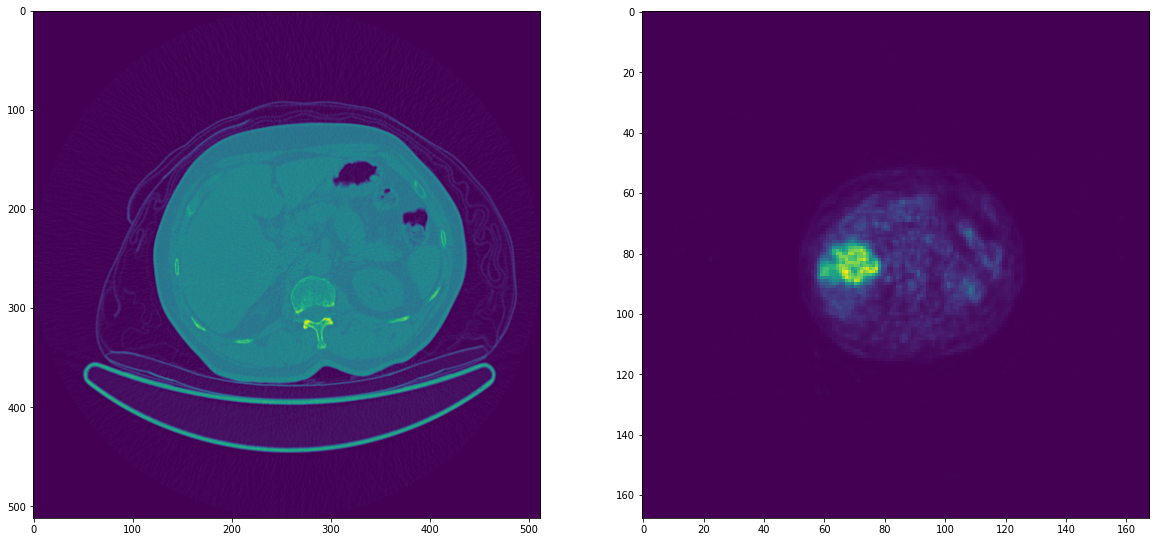

In [7]:
ct = streamer.get('1', 'CT PLAIN')[362]
pt = streamer.get('1', 'PET WB  (AC)')[362]

plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
plt.imshow(ct)
plt.subplot(1,2,2)
plt.imshow(pt)

In [8]:
num_pts = 5

In [9]:
%matplotlib notebook
def Interactive_Plot(a_args, b_args, num_pts, fig_size):
    
    img_a, cmap_a = a_args
    img_b, cmap_b = b_args
    
    a_pts = []
    b_pts = []
    
    fig = plt.figure(figsize = fig_size)
    a = fig.add_subplot(121)
    a.imshow(img_a, cmap = cmap_a)
    b = fig.add_subplot(122)
    b.imshow(img_b, cmap = cmap_b)
    
    def onclick(event):
        if event.inaxes == a:
            if event.button == 1:
                if len(a_pts) < num_pts:
                    a_pts.append((int(event.xdata), int(event.ydata)))
                    a.text(0, 0, f"{a_pts}", va="bottom", ha="left")
        elif event.inaxes == b:
            if event.button == 1:
                if len(b_pts) < num_pts:
                    b_pts.append((int(event.xdata), int(event.ydata)))
                    b.text(0, 0, f"{b_pts}", va="bottom", ha="left")
                
    cid = fig.canvas.mpl_connect('button_press_event', onclick)
    return a_pts, b_pts

<IPython.core.display.Javascript object>


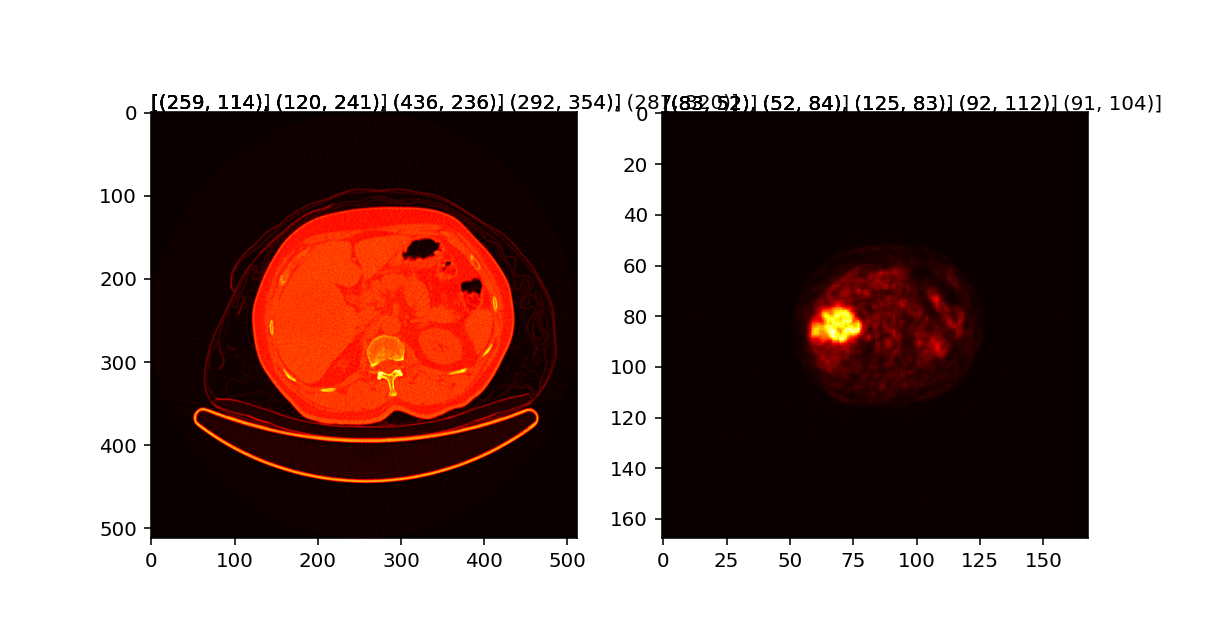

In [10]:
ct_arguments = (ct, 'hot')
pt_arguments = (pt, 'hot')
num_pts = 5
figure_size = (4, 4)
ct_pts, pt_pts = Interactive_Plot(ct_arguments, pt_arguments, num_pts, figure_size)

In [11]:
ct_pts = np.asarray(ct_pts)
ct_pts

array([[259, 114],
       [120, 241],
       [436, 236],
       [292, 354],
       [287, 320]])

In [12]:
pt_pts = np.asarray(pt_pts)
pt_pts

array([[ 83,  52],
       [ 52,  84],
       [125,  83],
       [ 92, 112],
       [ 91, 104]])

In [13]:
import registration

In [14]:
t_obj = registration.TransFormation(ct, pt, ct_pts, pt_pts)

In [15]:
t_obj.info()

{'rows': '512',
 'columns': '512',
 'reference_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 'transformed_img': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint16),
 'Transform_values': {'rotation': array([[ 0.99998955,  0.00457164],
         [-0.00457164,  0.99998955]]),
  'scale': 4.171002333784718,
  'translation': array([ -89.08800131, -111.56286394])}}

In [16]:
img_tr = t_obj.transform(pt)

In [17]:
%matplotlib inline
def PLOT(img, cmap, f_size):
    plt.figure(figsize = f_size)
    plt.imshow(img, cmap = cmap)
    
def NORMALIZE(img):
    return cv2.normalize(img, None, 0, 255, cv2.NORM_MINMAX, dtype = cv2.CV_8U)

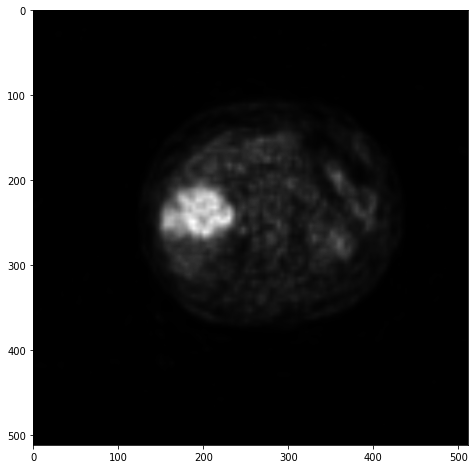

In [18]:
PLOT(img_tr, 'gray', (8, 8))

In [20]:

ct_frames = streamer.get('1', 'CT PLAIN')
pt_frames = streamer.get('1', 'PET WB  (AC)')

for ct, pt in zip(ct_frames, pt_frames):
    
    pt = t_obj.transform(pt)
    
    ct = NORMALIZE(ct)              
    pt = NORMALIZE(pt)
    
    cv2.imshow('CT Image', ct)
    cv2.imshow('PET Image', pt)
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
        
cv2.destroyAllWindows()

F:\Final Year Project\Data Pipeline\TestDataBase_2\1\CT PLAIN.pickle.gzip
F:\Final Year Project\Data Pipeline\TestDataBase_2\1\PET WB  (AC).pickle.gzip


In [21]:
import pywt

In [22]:
# This function does the coefficient fusing according to the fusion method
def fuseCoeff(cooef1, cooef2, method):

    if (method == 'mean'):
        cooef = (cooef1 + cooef2) / 2
    elif (method == 'min'):
        cooef = np.minimum(cooef1,cooef2)
    elif (method == 'max'):
        cooef = np.maximum(cooef1,cooef2)
    else:
        cooef = []

    return cooef

In [37]:

def Fusion_Method_1(img_a, img_b):
    
    # Params
    FUSION_METHOD = 'mean' # Can be 'min' || 'max || anything you choose according theory

    # Read the two image
    I2 = img_a
    I1 = img_b

    # We need to have both images the same size
    # I2 = cv2.resize(I2,I1.shape) # I do this just because i used two random images

    ## Fusion algo

    # First: Do wavelet transform on each image
    wavelet = 'haar'
    cooef1 = pywt.wavedec2(I1[:,:], wavelet)
    cooef2 = pywt.wavedec2(I2[:,:], wavelet)
    # print(cooef1)
    # print(cooef2)

    # Second: for each level in both image do the fusion according to the desire option
    fusedCooef = []
    for i in range(len(cooef1)-1):

        # The first values in each decomposition is the apprximation values of the top level
        if(i == 0):

            fusedCooef.append(fuseCoeff(cooef1[0],cooef2[0],FUSION_METHOD))

        else:

            # For the rest of the levels we have tupels with 3 coeeficents
            c1 = fuseCoeff(cooef1[i][0], cooef2[i][0], FUSION_METHOD)
            c2 = fuseCoeff(cooef1[i][1], cooef2[i][1], FUSION_METHOD)
            c3 = fuseCoeff(cooef1[i][2], cooef2[i][2], FUSION_METHOD)

            fusedCooef.append((c1,c2,c3))

    # Third: After we fused the cooefficent we need to transfor back to get the image
    fusedImage = pywt.waverec2(fusedCooef, wavelet)

    # Forth: normmalize values to be in uint8
    fusedImage = np.multiply(np.divide(fusedImage - np.min(fusedImage),(np.max(fusedImage) - np.min(fusedImage))),255)
    fusedImage = fusedImage.astype(np.uint8)

    return fusedImage

In [42]:
# cv2.namedWindow('Fusion method 1',cv2.WINDOW_NORMAL)
# cv2.resizeWindow('Fusion method 1', 600,600)

for ct, pt in zip(ct_frames, pt_frames):
    
    pt = t_obj.transform(pt)
    
    ct = NORMALIZE(ct)
    pt = NORMALIZE(pt)
    
    cv2.imshow('Fusion method 1', Fusion_Method_1(ct, pt))
    
    if cv2.waitKey(0) & 0xFF == ord('q'):
        break
    
cv2.destroyAllWindows()

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(np.random.rand(10))
text=ax.text(0,0, "", va="bottom", ha="left")

def onclick(event):
    tx = 'button=%d, x=%d, y=%d, xdata=%f, ydata=%f' % (event.button, event.x, event.y, event.xdata, event.ydata)
    text.set_text(tx)

cid = fig.canvas.mpl_connect('button_press_event', onclick)